In [ ]:
# If not installed, run this cell. It is needed for the determination of the recession constant
#!pip install hydrosignatures
#!pip show hydrosignatures

In [ ]:
#!pip install pygeohydro
#!pip show pygeohydro

In [ ]:
# The following two lines had to be executed to correct the library installations that the above libraries carried out when intalling
#!pip install -U --force-reinstall scipy
#!pip install matplotlib --upgrade
#!pip install aiohttp --upgrade

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import hydrosignatures as hs
from pygeohydro import NWIS

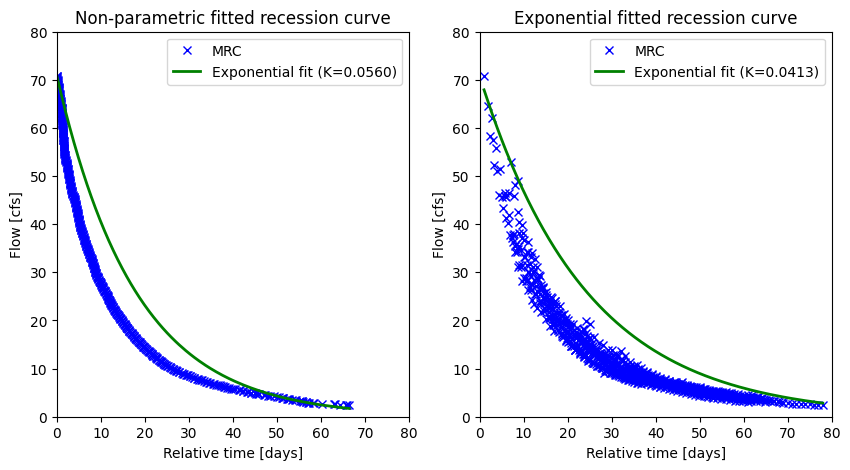

In [ ]:
nwis = NWIS()
q = nwis.get_streamflow("12304500", ("2000-01-01", "2019-12-31"))
mrc_np, bfr_k_np = hs.baseflow_recession(q, fit_method="nonparametric_analytic")
mrc_exp, bfr_k_exp = hs.baseflow_recession(q, fit_method="exponential")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=100)

ax1.plot(mrc_np[:, 0], mrc_np[:, 1], "bx")
ax1.plot(
    np.sort(mrc_np[:, 0]),
    np.exp(np.log(mrc_np[0, 1]) - bfr_k_np * np.sort(mrc_np[:, 0])),
    "g-",
    linewidth=2,
)
ax1.set_xlabel("Relative time [days]")
ax1.set_ylabel("Flow [cfs]")
ax1.set_xlim(0, 80)
ax1.set_ylim(0, 80)
ax1.set_title("Non-parametric fitted recession curve")
ax1.legend(["MRC", f"Exponential fit (K={bfr_k_np:.4f})"])

ax2.plot(mrc_exp[:, 0], mrc_exp[:, 1], "bx")
ax2.plot(
    np.sort(mrc_exp[:, 0]),
    np.exp(np.log(mrc_exp[0, 1]) - bfr_k_exp * np.sort(mrc_exp[:, 0])),
    "g-",
    linewidth=2,
)
ax2.set_xlabel("Relative time [days]")
ax2.set_ylabel("Flow [cfs]")
ax2.set_xlim(0, 80)
ax2.set_ylim(0, 80)
ax2.set_title("Exponential fitted recession curve")
ax2.legend(["MRC", f"Exponential fit (K={bfr_k_exp:.4f})"])

In [12]:
x = list(mrc_np[:, 0])
y = list(mrc_np[:, 1])

# Fit a linear regression model
coefficients = np.polyfit(x, np.log(y), 1, w=np.sqrt(y)) # Use of weights (w) to avoid bias towards small values
generated_x = np.linspace(min(x), max(x), 100)
beta = np.exp(coefficients[1])
alpha = coefficients[0]
print("The alpha value differs from the example when a weight is assigned in the 'polyfit' function :", round(alpha, 4))

# Fit a linear regression model
coefficients2 = np.polyfit(x, np.log(y), 1) # Use of weights (w) to avoid bias towards small values
generated_x2 = np.linspace(min(x), max(x), 100)
beta2 = np.exp(coefficients2[1])
alpha2 = coefficients2[0]
print("The alpha value is the same value that that from the example when a weight is not assigned in the 'polyfit' function :", round(alpha2, 4))

The alpha value differs from the example when a weight is assigned in the 'polyfit' function : -0.0669
The alpha value is the same value that that from the example when a weight is not assigned in the 'polyfit' function : -0.056


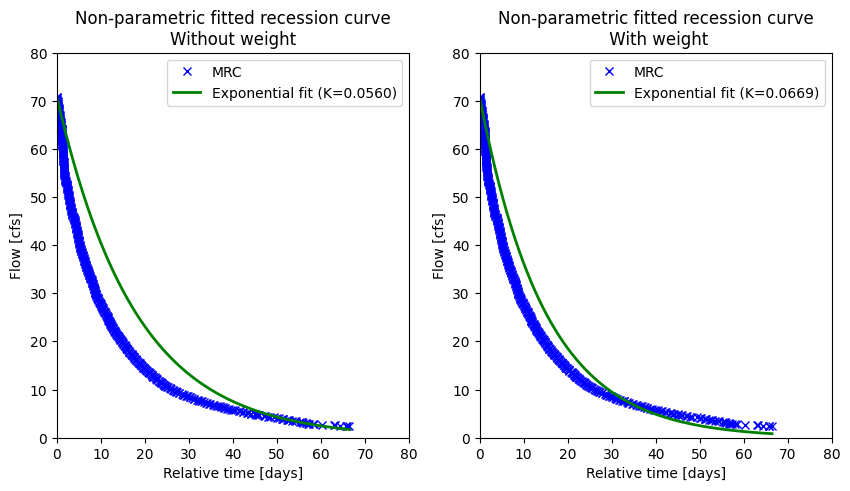

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=100)

ax1.plot(mrc_np[:, 0], mrc_np[:, 1], "bx")
ax1.plot(
    np.sort(mrc_np[:, 0]),
    np.exp(np.log(mrc_np[0, 1]) - abs(alpha2) * np.sort(mrc_np[:, 0])),
    "g-",
    linewidth=2,
)
ax1.set_xlabel("Relative time [days]")
ax1.set_ylabel("Flow [cfs]")
ax1.set_xlim(0, 80)
ax1.set_ylim(0, 80)
ax1.set_title("Non-parametric fitted recession curve\nWithout weight")
ax1.legend(["MRC", f"Exponential fit (K={abs(alpha2):.4f})"])

ax2.plot(mrc_np[:, 0], mrc_np[:, 1], "bx")
ax2.plot(
    np.sort(mrc_np[:, 0]),
    np.exp(np.log(mrc_np[0, 1]) - abs(alpha) * np.sort(mrc_np[:, 0])),
    "g-",
    linewidth=2,
)
ax2.set_xlabel("Relative time [days]")
ax2.set_ylabel("Flow [cfs]")
ax2.set_xlim(0, 80)
ax2.set_ylim(0, 80)
ax2.set_title("Non-parametric fitted recession curve\n With weight")
ax2.legend(["MRC", f"Exponential fit (K={abs(alpha):.4f})"])

In [19]:
corr_matrix = np.corrcoef(mrc_np[:, 1], np.exp(np.log(mrc_np[0, 1]) - abs(alpha2) * np.sort(mrc_np[:, 0])))
corr = corr_matrix[0,1]
R_sq = corr**2
print("Coeffcient of determination with alpha value =", abs(round(alpha2, 4)), "is", round(R_sq, 3))

corr_matrix2 = np.corrcoef(mrc_np[:, 1], np.exp(np.log(mrc_np[0, 1]) - abs(alpha) * np.sort(mrc_np[:, 0])))
corr2 = corr_matrix2[0,1]
R_sq2 = corr2**2
print("Coeffcient of determination with alpha value =", abs(round(alpha, 4)), "is", round(R_sq2, 3))

Coeffcient of determination with alpha value = 0.056 is 0.955
Coeffcient of determination with alpha value = 0.0669 is 0.972


**"hs.baseflow_recession()"**: Calculate baseflow recession constant and master recession curve.

*Notes*\
This function is ported from the TOSSH Matlab toolbox, which is based on the following publication:

- Gnann, S.J., Coxon, G., Woods, R.A., Howden, N.J.K., McMillan H.K., 2021. TOSSH: A Toolbox for Streamflow Signatures in Hydrology. Environmental Modelling & Software. https://doi.org/10.1016/j.envsoft.2021.104983

This function calculates baseflow recession constant assuming exponential recession behaviour (Safeeq et al., 2013). Master recession curve (MRC) is constructed using the adapted matching strip method (Posavec et al., 2006).

According to Safeeq et al. (2013), K < 0.065 represent groundwater dominated slow-draining systems, K >= 0.065 represent shallow subsurface flow dominated fast draining systems.

*Parameters*
- streamflow : numpy.ndarray\
    Streamflow as a 1D array.

- freq : float, optional\
    Frequency of steamflow in number of days. Default is 1, i.e., daily streamflow.

- recession_length : int, optional\
    Minimum length of recessions [days]. Default is 15.

- n_start : int, optional\
    Days to be removed after start of recession. Default is 0.

- eps : float, optional\
    Allowed increase in flow during recession period. Default is 0.

- start_of_recession : {'baseflow', 'peak'}, optional\
    Define start of recession. Default is 'baseflow'.

- fit_method : {'nonparametric_analytic', 'exponential'}, optional\
    Method to fit mrc. Default is 'nonparametric_analytic'.

- lyne_hollick_smoothing : float, optional\
    Smoothing parameter of Lyne-Hollick filter. Default is 0.925.

*Returns*
- mrc : numpy.ndarray\
    Master Recession Curve as 2D array of [time, flow].

* bf_recession_k : float\
    Baseflow Recession Constant [1/day].

*Raises*
- ValueError\
    If no recession segments are found or if a complex BaseflowRecessionK is calculated.